$\LARGE{\textbf{AN EVENT DRIVEN CARROM SIMULATOR}}$  
By Ankur Barsode

* This work is based on event driven N-Body simulation method. I came up with the algorithm independently.  
* All the physics modules and the simulator engine are written from scratch using Numpy. All visualizations are done with Matplotlib.
* The physics modelling is explained with the code. A short summary of the assumptions made is given below. Based on my experience of playing the actual game, these assumptions describe a carrom board quite well.
  * Coins undergo rectilinear motion over the uniformly rough surface of the board with a known (may be coin specific) coefficient of friction
  * All collisions between the coins and with walls are inelastic hard disk collisions with known (may be coin specific) coefficient of restitution
  * A coin sinks if it free falls for more than a specified depth (may be coin specific) inside a hole during its 2D motion over the same hole. 3D rotation is neglected.
* This basic version can generate random initial conditions, simulate the motion of the coins and make a plot to vizualize the motion.  
* Future work
  * Experimental determination of physical parameters
  * Testing the accuracy of the simulator with respect to a real board
  * Generating large amount of data and using ANNs to find the optimum configuration for best sinks in the first shot

To run, click on **Kernel $\rightarrow$ Restart Kernel and Run All Cells...** and scroll down to the last cell. For reruns, simply run the last cell again.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

$\Large{\textbf{1. Physics}}$  
  
In this section, I will describe the basic modules used for calculating the physics. These involve motion of coins between collisions, collision detection, performing these collisions, and sinking.  
Here and everywhere, the terms "coin" and "particle" will be used to refer to all the disks used in the board, including the 18 carrom people, 1 Queen/King and the striker.  
I will start by defining the global constants.

$\large{\textbf{1.1. Dimensions in S.I. units}}$  
$\textbf{1.1.1. Standard}$    
Source: http://www.indiancarrom.co.in/laws-of-carrom/

In [2]:
L = 0.7375 # m, Length of the inner edge of the board
Rh = 0.02225 # m, Hole Radius
Rs = 0.0205 # m, Striker Radius
Rc = 0.0155 # m, Striker Radius
ms = 0.015 # kg, Striker mass
mc = 0.005375 # kg, Coin mass
g = 9.80665 # ms^-2, gravitational acceleration

distance_accuracy = 1e-7 # m, Accuracy of the code in calculating collsion distances

$\textbf{1.1.2. Experimental}$   
Currently these are set to some canonical values

In [3]:
e_cc = 0.5 # Coefficient of restitution between two coins ##### NEEDS REVISION
e_cw = 0.5 # Coefficient of restitution between coin and wall ##### NEEDS REVISION
e_cs = 0.5 # Coefficient of restitution between coin and striker ##### NEEDS REVISION
e_sw = 0.5 # Coefficient of restitution between striker and wall ##### NEEDS REVISION
mu_c = 0.1 # Coefficient of friction between coin and board surface ##### NEEDS REVISION
mu_s = 0.1 # Coefficient of friction between striker and board surface ##### NEEDS REVISION
zmax_c = 0.0005 # m, Maximum free fall height for coin that can be allowed return to board ##### NEEDS REVISION
zmax_s = 0.0005 # m, Maximum free fall height for striker that can be allowed return to board ##### NEEDS REVISION

$\textbf{1.1.3. Coordinate system}$  
The system of coordinates is defined as follows:
1. The origin of coordinates is at the exact center of the board.
2. The x axis is parallel to the horizontal edges of the board when seen from top
3. The y axis is parallel to the vertical edges of the board when seen from top
4. The edges of the board are defined by $x=\pm(0.5L),\ y=\pm(0.5L)$
5. The holes are given IDs -1, -2, -3, -4 and are located at  
    Hole (-1): $\left(0.5L-R_{hole},\ 0.5L-R_{hole}\right)$  
    Hole (-2): $\left(-0.5L+R_{hole},\ 0.5L-R_{hole}\right)$  
    Hole (-3): $\left(-0.5L+R_{hole},\ -0.5L+R_{hole}\right)$  
    Hole (-4): $\left(0.5L-R_{hole},\ -0.5L+R_{hole}\right)$  
  
![title](./assets/coordinate_system_small.png)  

In [4]:
Hole_Locations = {-1:np.array([(L/2.0 - Rh), (L/2.0 - Rh)]),\
                  -2:np.array([-(L/2.0 - Rh), (L/2.0 - Rh)]),\
                  -3:np.array([-(L/2.0 - Rh), -(L/2.0 - Rh)]),\
                  -4:np.array([(L/2.0 - Rh), -(L/2.0 - Rh)])}

Hole_IDs = {(1, 1):-1, (-1, 1):-2, (-1, -1):-3, (1, -1):-4}

$\large{\textbf{1.2. Rectilinear Propagation}}$  
  
I model the motion of a coin on the surface of the board as the motion of a point mass moving on a rough surface with coefficient of friction $\mu$. As the force of friction always opposes the relative motion between rubbing bodies, and since the coin is considered to be a point mass, the acceleration is always in the direction opposite to the velocity vector and the coin moves in a rectillinear fashion between collisions.  
  
Let $\textbf{r}_{i}$ be the initial (t=0) position vector and $\textbf{v}_{i}$ be the initial velocity vector.  
When $\textbf{v}_{i} \ne 0$, we have $$\textbf{a} = -\mu g \hat{\textbf{v}}$$ where $\hat{\textbf{v}}$ is a unit vector (a constant for rectillinear motion) in the direction of $\textbf{v}_{i}$ and $g$ is the acceleration due to gravity.  
  
The coefficient of friction $\mu$ can in general be different for different coin types (such as the striker). I combine $g$ and $\mu$ to make a single frictional force parameter "$mug$".  
  
At a time $t\ (>0)$, the coin's velocity is given by $$\textbf{v}_{f} = \textbf{v}_{i} - t \times mug \hat{\textbf{v}}$$
This coin would come to a halt and remain stationary if $$t \ge t_{halt} = \frac{\lvert \textbf{v}_{i} \lvert}{mug}$$
For any time $t<t_{halt}$, the coin's position is given by $$\textbf{r}_{f} = \textbf{r}_{i} + \textbf{v}_{i}t - 0.5t^2 \times mug \hat{\textbf{v}}$$

In [5]:
def rectillinear(ri, vi, mug, t):
    # r and v are numpy arrays of dimension (2,)
    # mug and t are scalars
    if vi[0]==0 and vi[1]==0:
        vcap = 0
    else:
        vcap = vi / np.linalg.norm(vi)
    t = np.min([np.linalg.norm(vi) / mug, t])
    vf = vi - mug * t * vcap
    rf = ri + vi * t - 0.5 * mug * t**2 * vcap
    return rf, vf, t

$\large{\textbf{1.3. Collisions}}$  
  
$\textbf{1.3.1 Collision Detection}$  
Two objects of radii $R_1$ and $R_2$ will collide if the distance between them becomes equal to $R_1+R_2$. This definition unambiguously includes collisions between coins and walls when the point of contact is taken to be the center of the wall and the radius of the wall is taken to be zero.  
  
For the case of collision between two coins, the time of collision $t_c$ is given by the smallest positive root of the following equation
$$\lvert \textbf{r}_1(t) - \textbf{r}_2(t) \rvert ^2 - (R_1+R_2)^2 = 0$$ 
While for the case of wall collisions, the time of collision $t_c$ is given by the smallest positive root of $both$ of the following equations
$$\lvert r_x \rvert + R - 0.5L = 0$$
$$\lvert r_y \rvert + R - 0.5L = 0$$
where $r_x\hat{i}+r_y\hat{j}=\textbf{r}(t)$, L is length of the inner edge of the board and R is the radius of the colliding coin. These simplify to the following when we consider that if the sign of the velocity component $v_x$ or $v_y$ is positive (negative), the coin will only collide with the positive (negative) wall in the corresponding direction. When a component is exactly zero, its sign is considered positive.
$$r_x + (R - 0.5L).sign(v_x) = 0$$
$$r_y + (R - 0.5L).sign(v_y) = 0$$
  
I use the Newton-Raphson method for obtaining the roots. A python function is first used to define the above functions. Wall-coin and coin-coin collision cases are handled separately.  
For coin-coin collisions, the function is  
$$f(t) = \lvert \textbf{r}_1(t) - \textbf{r}_2(t) \rvert - \lvert R_1+R_2\rvert$$ 
For coin-wall collisions, the functions are  
$$fx(t) = r_x + (R - 0.5L).sign(v_x)$$
$$fy(t) = r_y + (R - 0.5L).sign(v_y)$$
  
Time of collision is calculated down to 0.1$\mu m$ (default) accuracy in terms of the distance between the two objects' surfaces.  
If the calculated time of collision is negative, or if the the maximum allowed iterations in the Newton-Raphson root finder are reached, the time of collision is set to a very large number. Otherwise, the time of collision, along with the position and velocity vectors of both the objects at the point of collision are returned.

In [6]:
def NewtonRaphson(func, guess=0, maxiter=50, dt=1e-8):
    global distance_accuracy
    for i in range(maxiter+1):
        f0 = func(guess)
        f1 = func(guess+dt)
        dfunc = f1 - f0
        if dfunc != 0:
            delta = dt * f0 / dfunc
        else:
            i = maxiter
            break
        guess -= delta
        if np.abs(f0) <= distance_accuracy:
            break
    return guess, i

def create_NR_func(a, mode):
    if mode == 'cc':
        def func(t):
            x1, y1 = rectillinear(a[0], a[2], a[4], t)[0]
            x2, y2 = rectillinear(a[1], a[3], a[5], t)[0]
            f = ((x2-x1)**2 + (y2-y1)**2) ** 0.5 - np.abs(a[6] + a[7])
            return f
            
    if mode == 'wcx':
        def func(t):
            f = rectillinear(a[0], a[1], a[2], t)[0][0] - a[4]/2.0 + a[3]
            return f
        
    if mode == 'wcy':
        def func(t):
            f = rectillinear(a[0], a[1], a[2], t)[0][1] - a[4]/2.0 + a[3]
            return f
        
    if mode == 'ch':
        None
    return func

In [7]:
def detect_coin_collision(r1i, r2i, v1i, v2i, mug1, mug2, R1, R2, tguess=0):
    func = create_NR_func([r1i, r2i, v1i, v2i, mug1, mug2, R1, R2], mode='cc')
    maxiter = 50
    t, i = NewtonRaphson(func, guess=tguess, maxiter=maxiter)
    if i >= maxiter or t <= 0: 
        t = 1e10
    r1f, v1f, _ = rectillinear(r1i, v1i, mug1, t)
    r2f, v2f, _ = rectillinear(r2i, v2i, mug2, t)
    return t, r1f, r2f, v1f, v2f

def detect_wall_collision(ri, vi, R, mug, L):
    if vi[0] == 0 and vi[1] == 0:
        vi += 1e-15
    fx = create_NR_func([ri, vi, mug, R*np.sign(vi[0]), L*np.sign(vi[0])], mode='wcx')
    fy = create_NR_func([ri, vi, mug, R*np.sign(vi[1]), L*np.sign(vi[1])], mode='wcy')
    maxiter = 50
    tx, ix = NewtonRaphson(fx, maxiter=maxiter)
    ty, iy = NewtonRaphson(fy, maxiter=maxiter)
    if tx <= 0 or ix > maxiter:
        if ty <= 0 or iy > maxiter:
            t = 1e10
            rf, vf, rcontact = ri, vi, np.array([1e10, 1e10])
        else:
            t = ty
            rf, vf, _ = rectillinear(ri, vi, mug, t)
            rcontact = rf + np.array([0,R*np.sign(rf[1])])
    else:
        if ty <= 0 or iy > maxiter or ty > tx:
            t = tx
            rf, vf, _ = rectillinear(ri, vi, mug, t)
            rcontact = rf + np.array([R*np.sign(rf[0]),0])
        elif ty <= tx:
            t = ty
            rf, vf, _ = rectillinear(ri, vi, mug, t)
            rcontact = rf + np.array([0,R*np.sign(rf[1])])
    return t, rf, vf, rcontact

$\textbf{1.3.2. Performing Collisions}$  
I model all collisions as inelastic hard disk collisions.  
  
Let  
$e$ be the coefficient of restitution  
$m_1,\ m_2$ be the masses of the two objects  
  
Before the collision, let  
$\textbf{r}_1,\ \textbf{r}_2$ be the positions of the two objects  
$\textbf{u}_1,\ \textbf{u}_2$ be the velocities of the two objects  
$\textbf{r}_{21} = \textbf{r}_2 - \textbf{r}_1$ be the relative position of object 2 with respect to object 1  
$\textbf{u}_{21} = \textbf{u}_2 - \textbf{u}_1$ be the relative velocity of object 2 with respect to object 1  
  
![title](./assets/collision_notation_small.png)  
  
The initial angle $\theta$ between $\textbf{u}_{21}$ and $\textbf{r}_{21}$ is given by $$\theta = \pi - cos^{-1}(\hat{\textbf{u}}_{21} . \hat{\textbf{r}}_{21})$$
The angle after collision is given by $$\alpha = tan^{-1}\left(\dfrac{1+\frac{m2}{m1}}{e-\frac{m2}{m1}} .tan\ \theta \right)$$
Note that for collisions of coins with walls, $m_1$ is the wall and $\frac{m_2}{m_1}=0$  
In terms of $\theta,\ \alpha$ and $u_{21}=\lvert \textbf{u}_{21} \rvert$, the speeds of the two objects after collision in the rest frame (before collision) of object 1 are given by
$$v_{21} = \dfrac{u_{21}.sin\ \theta}{sin\ \alpha}$$
$$v_{11} = e.u_{21}.cos\ \theta-\dfrac{u_{21}.sin\ \theta}{tan\ \alpha}$$

Converting back to the rest frame of the board, we get the velocities after collision $\textbf{v}_1,\ \textbf{v}_2$ as
$$\textbf{v}_1 = \textbf{u}_1 - v_{11}\hat{\textbf{r}}_{21}$$
$$\textbf{v}_2 = \textbf{u}_1 + cos\ \alpha\ v_{21}\hat{\textbf{r}}_{21} + sin\ \alpha\ v_{21} \dfrac{\hat{\textbf{u}}_{21} + cos\ \theta\ \hat{\textbf{r}}_{21}}{sin\ \theta}$$
  
In the actual code, errors occur in special conditions due to values being exactly zero or being slightly out of the domain. These have been dealt with by adding a small offset of 1e-15.

In [8]:
def perform_hard_collision(r1, r2, u1, u2, m1, m2, e):
    mratio = m2 / m1 * (m1 > 0) # m1=-1 for wall
    if e == mratio:
        e += 1e-15
    u21 = np.linalg.norm(u2 - u1)
    if u21 != 0:
        u21cap = (u2 - u1) / u21
    else:
        u21cap = 1e-15
    r21cap = (r2 - r1) / np.linalg.norm(r2 - r1)
    if np.sum(u21cap * r21cap) > 1:
        theta = np.pi
    elif np.sum(u21cap * r21cap) < -1:
        theta = 0
    else:
        theta = np.pi - np.arccos(np.sum(u21cap * r21cap))
    alpha = np.arctan((1 + mratio) / (e - mratio) * np.tan(theta))
    if theta == 0 or theta == np.pi: # To avoid nan in v2 for head-on collisions
        theta += 1e-15
        alpha += 1e-15
    v21 = u21 * np.sin(theta) / np.sin(alpha)
    v11 = e * u21 * np.cos(theta) - v21 * np.cos(alpha)
    v1 = u1 - v11 * r21cap
    v2 = u1 + v21 * np.cos(alpha) * r21cap + v21 * np.sin(alpha) * (u21cap + np.cos(theta) * r21cap) / np.sin(theta)
    return v1, v2

$\large{\textbf{1.4. Sinking}}$  
  
Sinking is approximated by following these assumptions:  
1. Motion in z: A coin is in free fall as long as its center is inside the hole's circumference.  
2. Hole walls: The coin can undergo usual inelastic collisions with the bounding wall of the hole. (There is a complication that the walls are not exactly flat, but have a fillet at the corner. This will be dealt with properly.)  
3. Return to the board: If the coin spends an amount of time $=\ t_{hole}$ over the hole (where it might be travelling to a wall/fillet, colliding with it, and return) before its center touches the circumference of the hole again,  
and if $t_{hole} < t_{zmax}$, with $t_{zmax} = \sqrt{\dfrac{2z_{max}}{g}}$, it can return to the board. Otherwise it sinks.  
Here, $z_{max}$ is the maximum drop allowed for the coin to be able to return to the board after passing over the hole.  
4. If there are multiple coins in the same hole region, they will interact the same way as they would have if they had been on the board. This will go on until any of them sink or return to the board.  
5. Friction is negligible over the hole. I.e. $mug=0$ for a coin whose center is inside the hole circumference.
6. 3D rotation is negligible.  
  
With these assumptions, the only tasks required to be performed are detecting and performing collisions with a hole, while carefully taking the fillet into account. Rest will be taken care of by simply setting friction equal to zero and keeping track of time.

$\textbf{1.4.1. Detecting Collisions With Holes}$  
If a coin is on the board, the location of the only hole it may immediately collide with is fixed by the direction of its velocity. A coin moving towards, for example, +x and -y direction (i.e. $sign(\textbf{v}) = (+1, -1)$ will never enter a hole located at, say, $\left(-\frac{L}{2}+R_{h},\ -\frac{L}{2}+R_{h}\right)$. The only hole a coin may collide with is given by $\left((\frac{L}{2}-R_{h})\times sign(v_x),\ (\frac{L}{2}-R_{h})\times sign(v_y)\right)$.  
  
The collision is similar to any other coin-coin collision except that the hole can allow the coin to enter its disk. The collision is said to occur (assumption 1 in section 1.4) when the distance between the centers of the coin and the hole is equal to $R_{h}$. This can be accomplished by the simple coin-coin collision detection module by setting the hole's radius $R_{hole}$ equal to $R_{h}-R_{coin}$. Note that any coin outside a particular hole can never collide with the fillet bounding that hole without passing through that hole first.  
  
A fillet occupies a quarter of the hole's boundary, and is located in the same direction with respect to the hole's center as the hole's center is located with respect to the origin. The fillet's endpoints are therefore given by
$$\textbf{P}_1 = \textbf{r}_h+sign(\textbf{r}_h)\times(R_h,0)$$
$$\textbf{P}_2 = \textbf{r}_h+sign(\textbf{r}_h)\times(0,R_h)$$
In order to determine of the coin which is already inside the hole is going in the direction of the fillet, the equation of its linear trajectory was computed  
$$l(\textbf{r})=v_{yi}(r_x-r_{xi})-v_{xi}(r_y-r_{yi})$$
where $\textbf{r}$ is the position parameter with components $r_x,r_y$, and $r_{xi},r_{yi},v_{xi},v_{yi}$ are the components of initial position and velocity vectors. The velocities remain constant because there is no friction inside the hole. A coin will collide with a fillet if the two endpoints $P_1$ and $P_2$ are on different sides of the linear trajectory of the coin. This can be easily checked by calculating and comparing the signs of $l(\textbf{P}_1)$ and $l(\textbf{P}_2)$. If the signs are equal, the coin will not collide with the fillet and vice versa. Moreover, since both incoming and outgoing directions give opposite signs for $l(\textbf{P}_1)$ and $l(\textbf{P}_2)$, for the collision to occur, the coin must be moving in the same general direction of the fillet given by the sign of its velocity components (similar to how a coin must move in the same general direction of the hole's center's location in order to enter it).  
  
![title](./assets/fillet_collision_detection.png)  
  
If a coin over a hole is moving away from a fillet, I can use the usual coin-coin collision detection with $R_{hole}=R_{h}-R_{coin}$ as before. If a coin is moving towards a fillet, I can again use the coin-coin collision detection but with $R_{hole}=-R_{h}$ since the coin is inside the hole. Here, there is an additional complication that the coin-coin collision detector deals with full disks whereas the fillet occupies only a quarter of the hole. There are two possible points where the coin can collide with the virtual disk-like fillet and the correct one needs to be chosen.  
  
A coin's center will lie in the same general direction as the fillet with respect to the center of the hole if and only if it collides with the true fillet. This simple test can be used to determine whether the detected collision is genuine or not. If it is not, the collision occurs at a later time. The correct collision time can be determined by giving a better initial guess to the Newton-Raphson root finder.  
  
The trajectory of the coin cuts a chord in a circle of radius $R_h-R_c$ centered at the hole's center. One point of intersection corresponds to the virtual fillet collision, while the other corresponds to the real fillet collision. In case the first detection is that of the virtual collision, the second collision will take place after a time delay given by the length of the chord divided by the coin's speed (there is no friction inside the hole).
  
![title](./assets/virtual_fillet_collision.png)  
  
Using trigonometry, this time delay can be calculated as  
$$t_{delay}=2\left\lvert\dfrac{\textbf{v}.(\textbf{r}_h-\textbf{r})}{\lvert\textbf{v}\rvert^2}\right\rvert$$
where $\textbf{r}_h,\textbf{r},\textbf{v}$ are the location of the center of the hole and the position and velocity of the coin at the point of virtual fillet collision. Running another coin-coin collision detection with the initial guess equal of sum of previously detected collision time and the calculated delay now detects the true fillet collision.  
Similar issue occurs when the coin has just collided with the fillet where the root converges to a negative value for time. Here, similar time delay as calculated above can be used as the initial guess.

In [9]:
def detect_hole_collision(ri, vi, R, mug, hole, Rh, L):
    if hole == 0:
        rh = (L/2.0 - Rh) * np.sign(vi)
        Rhole = Rh - R
        fillet = False
    else:
        rh = Hole_Locations[hole]
        P1 = rh + Rh * np.sign(rh) * np.array([1,0])
        P2 = rh + Rh * np.sign(rh) * np.array([0,1])
        l1 = vi[1] * (P1[0] - ri[0]) - vi[0] * (P1[1] - ri[1])
        l2 = vi[1] * (P2[0] - ri[0]) - vi[0] * (P2[1] - ri[1])
        if np.sign(l1) != np.sign(l2) and np.sign(vi[0]) == np.sign(rh[0]) and np.sign(vi[1]) == np.sign(rh[1]):
            fillet = True
            Rhole = -Rh
        else:
            fillet = False
            Rhole = Rh - R
    t, _, rf, _, vf = detect_coin_collision(rh, ri, np.array([0,0]), vi, 1e-15, mug, Rhole, R)
    if t > 1e3:
        coin_in_fillet_region = (Hole_IDs[tuple(np.sign(ri - rh))] == hole)
    else:
        coin_in_fillet_region = (Hole_IDs[tuple(np.sign(rf - rh))] == hole)
    if t < 1e3 and fillet and not coin_in_fillet_region:
        tguess = t + 2 * np.abs(np.sum(vi * (rh - rf))) / np.linalg.norm(vi)**2
        t, _, rf, _, vf = detect_coin_collision(rh, ri, np.array([0,0]), vi, 1e-15, mug, Rhole, R, tguess=tguess)
    if t > 1e3 and (not fillet) and coin_in_fillet_region:
        tguess = 2 * np.abs(np.sum(vi * (rh - ri))) / np.linalg.norm(vi)**2
        t, _, rf, _, vf = detect_coin_collision(rh, ri, np.array([0,0]), vi, 1e-15, mug, Rhole, R, tguess=tguess)
    return t, rf, vf, rh, fillet

$\textbf{1.4.2. Performing Collisions With Holes}$  
Performing collisions with holes is a rather trivial matter. The only required task is to put the coin on the other side of the hole's circumference. The magnitude of the displacement is kept as small as possible, only two times the resolution of the code. Because it is so small, it is performed along the vector joining the coin and hole's centers instead of performing it along the direction of velocity of the coin. The latter would require making sure that the coin indeed crossed the boundary after the displacement. It may not always be so, since the velocity may even be tangential to the circumference of the hole in the worse case scenario, and the displacement will still keep it on the same side of the boundary. In addition to this assumption, the time taken for "collision" is neglected.  
  
The "collision" is accomplished by doing
$$\textbf{r}_f = \textbf{r}_i + 2\times (distance\ accuracy) \times \dfrac{\textbf{r}_h - \textbf{r}_i}{\lvert \textbf{r}_h - \textbf{r}_i \rvert}$$
for a coin initially outside the hole, and
$$\textbf{r}_f = \textbf{r}_i - 2\times (distance\ accuracy) \times \dfrac{\textbf{r}_h - \textbf{r}_i}{\lvert \textbf{r}_h - \textbf{r}_i \rvert}$$
for a coin initially inside the hole.  
Here $\textbf{r}_h,\textbf{r}_i,\textbf{r}_f$ respectively denote the location of the hole center and the initial and final positions of the coin.  

Fillet collisions are considered as inelastic collisions of coins with a virtual coin of infinite mass (set equal to -1 in the code), zero velocity, placed at the hole's center. However, since it is a collision with the concave surface, the direction of $\textbf{r}_{21} = \textbf{r}_2 - \textbf{r}_1$ needs to be reversed. Therefore, both $r_h$ and $r_i$ are negated before feeding to the hard disk collision performing module. In addition, the position is slightly modified to ensure that the coin remains on the concave side.

In [10]:
def perform_hole_collision(ri, vi, m, e, hole, fillet, Rh, L):
    global distance_accuracy
    if hole == 0:
        rh = (L/2.0 - Rh) * np.sign(vi)
        rf = ri + 2 * distance_accuracy * (rh - ri) / np.linalg.norm(rh - ri)
        vf = vi
    else:
        rh = Hole_Locations[hole]
        if fillet:
            _, vf = perform_hard_collision(-rh, -ri, np.array([0,0]), vi, -1, m, e)
            rf = rh + (ri - rh) * (1 - distance_accuracy / Rh)
        else:
            rf = ri - 2 * distance_accuracy * (rh - ri) / np.linalg.norm(rh - ri)
            vf = vi
    return rf, vf

$\Large{\textbf{2. Simulation}}$  
  
In this section, I will describe the Coin class and helper modules, followed by the queue system used for updating coin positions. Towards the end, I will complete my simulation engine.

$\large{\textbf{2.1. The Coin Class}}$  
  
All coins, including striker, are instances of the Coin class. A Coin object holds data regarding a coin's static properties such as its unique ID, radius, mass, board frictional deceleration coefficient $mug$ and the maximum time it can spend over a hole before sinking. It also holds dynamic information about the coin such as its current position and velocity, current frictional deceleration coefficient (this can be equal to $mug$ or zero depending on whether the coin is over the board or a hole), current hole status, and the amount of time spent over a single hole at that point of time. The Coin class also contains several functions for updating coin's data, keeping track of the coin's hole status, the time spent over a hole and whether it has already sunk.  
  
The $\textit{is_over_hole}$ function is used to keep track of the coin's hole status. First the position of the hole closest to the coin is found by using the sign of components of the coin's current position. Only if the Euclidean distance between the hole's center and the coin's center is smaller than the hole's radius, the coin will be over the hole, otherwise not. If the coin is over a hole, its hole status is updated to that hole's ID and its frictional deceleration coefficient is set to 0 (actually 1e-15 to avoid float division errors). Otherwise the coin's hole status is set to 0 and its frictional deceleration coefficient is set equal to $mug$.  
  
The $\textit{hole_time}$ function tracks the time spent by the coin over a hole. It first checks the hole status of the coin. If the coin is over a hole, the time delay provided in the function's argument is added to the "thole" parameter of the coin; otherwise thole is set to 0. Then the function returns the truth value of the statement: is the amount of time spent over the hole (given by self.thole) exceeds the maximum time it can spend over a hole before sinking (given by self.tholemax)?  
  
The $\textit{Update_After_Collision}$ function is used to update the position and velocity of a coin after it has undergone a collision. It takes the new position and velocity as arguments and substitutes over the old position and velocity data. It also checks the hole status of the coin after the update.  
  
The $\textit{Move_Rectilinearly}$ function is used to update the position and velocity of a coin rectilinearly for an amount of time provided as the function's argument. First the $\textit{hole_time}$ function is used to test whether the coin will sink within the given time delay or not. If the coin would sink, its position is changed to the location of the hole it is in, its velocity is made zero and its sink status is turned True. If the coin wouldn't sink, its position and velocity are updated using the rectilinear propagation function.

In [11]:
class Coin:
    def __init__(self, ID0, r0, v0, R, m, mu, zmax, h=0, th=0):
        global g
        self.sunk = False
        self.ID = ID0
        self.pos = r0
        self.vel = v0
        self.rad = R
        self.mass = m
        self.mug = mu * g
        self.fric = self.mug
        self.tholemax = np.sqrt(2 * zmax / g)
        self.hole = h
        self.thole = th
        
    def is_over_hole(self):
        global L, Rh
        rh = (L/2.0 - Rh) * np.sign(self.pos + 1e-15)
        if np.linalg.norm(rh-self.pos) - Rh <= 0:
            self.hole = Hole_IDs[tuple(np.sign(self.pos + 1e-15))]
            self.fric = 1e-15
            #print("Coin %d is over a hole"%self.ID)
        else:
            self.hole = 0
            self.fric = self.mug
            #print("Coin %d is not over a hole"%self.ID)
        
    def hole_time(self, delt):
        if self.hole < 0:
            self.thole += delt
        else:
            self.thole = 0
        if self.thole >= self.tholemax:
            return True
        else:
            return False
        
    def Update_After_Collision(self, r, v):
        self.pos = r
        self.vel = v
        self.is_over_hole()
        #print('Coin %d updated after collision to '%self.ID,self.pos)
        
    def Move_Rectilinearly(self, delt):
        global L, Rh
        #self.is_over_hole() # Redundant
        if self.hole_time(delt):
            self.pos = Hole_Locations[self.hole]
            self.vel = np.array([0, 0])
            self.sunk = True
            #print('Coin %d has sunk to'%self.ID,self.pos)
        else:
            self.pos, self.vel, _ = rectillinear(self.pos, self.vel, self.fric, delt)
            #print('Coin %d moved rectilinearly to '%self.ID,self.pos)

$\large{\textbf{2.2. Helper Functions}}$  

$\textbf{2.2.1. }$***initialize_Coin_objects***  
This function initializes all the Coin objects using the initial conditions from the file ic_file_name. It also returns one of the moving coins and the total number of moving coins in the initial state. Placeholder coins are also initialized for the holes and the wall.  
  
The initial conditions data must be written in the file such that the first line contains information about the field names and each line from the second line onwards contains the field values for each coin. There are 9 fields in order:
* Particle ID: Particle IDs are unique integers ascribed to each particle including coins, striker, wall, and holes. IDs -1, -2, -3, -4 are reserved for holes while ID 20 is reserved for the wall. The coins can take any other non-negative integer values for their ID. For standard games with 9 black coins, 9 white coins, 1 red "Queen" coin and 1 striker, for the sake of convenience, the striker is given an ID 0; the black coins are given IDs 1,3,5,...,17; the white coins are given IDs 2,4,6,...,18; and the Queen is given an ID of 19.
* x coordinate in m. Should be a real number within the carrom board dimensions, of the order of a few 1e-1.
* y coordinate in m. Should be a real number within the carrom board dimensions, of the order of a few 1e-1.
* x component of velocity in m/s. Should be a real number of the order of a few 1e-1.
* y component of velocity in m/s. Should be a real number of the order of a few 1e-1.
* Particle radius in m. Should be a positive real number of the order of a few 1e-2.
* Particle mass in kg. Should be a positive real number of the order of a few 1e-3.
* Particle mass in kg. Should be a positive real number of the order of a few 1e-3.
* Board frictional deceleration coefficient $\mu$. Should be a positive real number of the order of a few 1e-1.
* Maximum depth a particle can drop to in a hole and still return to the board, in m. Should be a positive real number of the order of a few 1e-4.

In [12]:
def initialize_Coin_objects(ic_file_name):
    IDs, posx, posy, velx, vely, radii, masses, fric_coeffs, zmax = np.loadtxt(ic_file_name, unpack=True, skiprows=0)
    coins = {}
    if IDs.shape == ():
        if velx != 0 or vely != 0:
            c = Coin(int(IDs), np.array([posx,posy]), np.array([velx,vely]), radii, masses, fric_coeffs, zmax)
            coins[c.ID] = c
            moving = 1
    else:
        positions, velocities = np.zeros((IDs.shape[0],2)), np.zeros((IDs.shape[0],2))
        positions[:,0], positions[:,1], velocities[:,0], velocities[:,1] = posx, posy, velx, vely
        moving = 0
        for i in range(positions.shape[0]):
            coin = Coin(int(IDs[i]), positions[i,:], velocities[i,:], radii[i], masses[i], fric_coeffs[i], zmax[i])
            coins[coin.ID] = coin
            if np.linalg.norm(velocities[i]) > 0:
                c = coin
                moving +=1
    for i in range(1,5):
        coins[-i] = Coin(-i, Hole_Locations[-i], np.zeros((2)), Rh, -1, 0, 0)
    coins[20] = Coin(20, np.zeros((2)), np.zeros((2)), L, -1, 0, 0)
    #print("%d coins initialized. %d are moving"%(len(coins)-5,moving))
    return coins, c, moving

$\textbf{2.2.2. }$***detect_all_collisions***  
This function detects all possible collisions a given coin may have at the given moment. It returns a list of possible collisions along with information about the most imminent collision.  
  
First, wall collision are checked, followed by hole collisions and finally collisions with other coins. Coins which have already sunk are exluded from the search. Each collision is stored as a list  
[time until collision,  
 second particle's ID, second particle's position, second particle's velocity,  
 first particle's ID, first particle's position, first particle's velocity,  
 whether it is a fillet collision (only in the case of hole collisions)]  
Here the first particle is the coin for which we are trying to detect all collisions. Therefore this particle cannot be a wall or a hole. The second particle is what the coin under consideration may collide with, and it can be another coin, hole or wall.

In [13]:
def detect_all_collisions(coins, c):
    global L, Rh
    miniq = []
    earliest_collision = [1e10, 1e10]
    
    tcol, rf, vf, rcontact = detect_wall_collision(c.pos, c.vel, c.rad, c.fric, L)
    if tcol < 1e3:
        collision = [tcol, 20, rcontact, np.array([0, 0]), c.ID, rf, vf]
        miniq.append(collision)
        if tcol < earliest_collision[0]:
            earliest_collision = collision[:]
        
    tcol, rf, vf, rh, fillet = detect_hole_collision(c.pos, c.vel, c.rad, c.fric, c.hole, Rh, L)
    if tcol < 1e3:
        collision = [tcol, Hole_IDs[tuple(np.sign(rh))], rh, np.array([0, 0]), c.ID, rf, vf, fillet]
        miniq.append(collision)
        if tcol < earliest_collision[0]:
            earliest_collision = collision[:]
        
    for coin_ID in coins:
        x = coins[coin_ID]
        if x.ID == c.ID or x.ID < 0 or x.ID == 20 or x.sunk:
            continue
        tcol, r1f, r2f, v1f, v2f = detect_coin_collision(c.pos, x.pos, c.vel, x.vel, c.fric, x.fric, c.rad, x.rad)
        if tcol < 1e3:
            collision = [tcol, x.ID, r2f, v2f, c.ID, r1f, v1f]
            miniq.append(collision)
            if tcol < earliest_collision[0]:
                earliest_collision = collision[:]
    #print('Detected collisions for coin %d'%c.ID,miniq)
    return miniq, earliest_collision

$\textbf{2.2.3. }$***initialize_queue***  
This function initializes the collision queue by checking all possible collisions that could occur at the begenning of the simulation. It returns a list of possible collisions along with information about the most imminent collision.  
  
Usually only the striker would be moving at the beginning and the rest of the coins would be stationary. In this case, the collision queue will consist of collisions of the striker only and the earliest collision will be the most imminent collision among them.  
However, if multiple coins are moving, all possible collisions of all the coins need to be checked.

In [14]:
def initialize_queue(coins, c, moving):
    if moving == 1:
        iniq, earliest_collision = detect_all_collisions(coins, c)
    else:
        iniq = []
        earliest_collision = [1e10, 1e10]
        keys = list(coins.keys())
        [keys.remove(ID) for ID in [-1,-2,-3,-4,20]]
        for i in range(len(keys)):
            mincoins = {keys[j]:coins[keys[j]] for j in range(i+1,len(keys))}
            miniq, earliest_collisionc = detect_all_collisions(mincoins, coins[keys[i]])
            iniq.extend(miniq)
            if earliest_collisionc[0] < earliest_collision[0]:
                earliest_collision = earliest_collisionc
    #print("Initial Queue ",iniq)
    return iniq, earliest_collision

$\textbf{2.2.4. }$***perform_earliest_collision***  
This function performs the earliest collision and updates the positions and velocities of the particles involved.

In [15]:
def perform_earliest_collision(earliest_collision, coins):
    global L, Rh, e_cc, e_cw, e_cs, e_sw
    if earliest_collision[4] == 0 or earliest_collision[1] == 0:
        e_wall = e_sw
        e_coin = e_cs
    else:
        e_wall = e_cw
        e_coin = e_cc
        
    if earliest_collision[1] < 0:
        c = coins[earliest_collision[4]]
        _, _, _, _, _, ri, vi, fillet = earliest_collision
        rf, vf = perform_hole_collision(ri, vi, c.mass, e_wall, c.hole, fillet,  Rh, L)
        #print('Performed hole collision of %d at'%c.ID,rf,vf)
        c.Update_After_Collision(rf, vf)
        
    elif earliest_collision[1] == 20:
        c = coins[earliest_collision[4]]
        _, _, rcontact, _, _, rf, vi = earliest_collision
        _, vf = perform_hard_collision(rcontact, rf, np.array([0,0]), vi, -1, c.mass, e_wall)
        #print('Performed wall collision of %d at'%c.ID,rf,vf)
        c.Update_After_Collision(rf, vf)
        
    else:
        c = coins[earliest_collision[4]]
        x = coins[earliest_collision[1]]
        _, _, r1f, v1i, _, r2f, v2i = earliest_collision
        v1f, v2f = perform_hard_collision(r1f, r2f, v1i, v2i, x.mass, c.mass, e_coin)
        c.Update_After_Collision(r2f, v2f)
        x.Update_After_Collision(r1f, v1f)
        #print('Performed coin collision of %d and %d at'%(c.ID,x.ID),r1f,v1f,r2f,v2f)

$\textbf{2.2.5. }$***update_state***  
This function, meant to be used after the earliest collision has been performed, is used for updating the positions and velocities of the rest of the coins which were not involved in the aforementioned collision. Coins which have already sunk are excluded from the updates.  

In [16]:
def update_state(coins, c, x, delt):
    for coin in coins:
        if coin == c.ID or coin == x.ID or coin < 0 or coin == 20 or coins[coin].sunk:
            continue
        coins[coin].Move_Rectilinearly(delt)
        #print("Coin %d moved rectilinearly by update_state for %f s"%(coins[coin].ID,delt))

$\textbf{2.2.6. }$***clean_queue***  
Once two particles have collided, all other possible collisions they could have had would not longer occur. Also, the time of collision in the remaining collisions will now be reduced by the time taken by this collision.  
This function performs the tasks of cleaning the queue of redundant collisions and updating the remaining future collisions' time until collision. It also finds the most imminent collision in the current queue.  

In [17]:
def clean_queue(in_queue, coins, c, x, delt):
    queue = []
    earliest_collision = [1e10,1e10]
    for collision in in_queue:
        if collision[1] == c.ID or collision[4] == c.ID or coins[collision[1]].sunk or coins[collision[4]].sunk:
            continue
        if (x.ID >= 0 and x.ID != 20) and (collision[1] == x.ID or collision[4] == x.ID):
            continue
        collision[0] -= delt
        queue.append(collision)
        if collision[0] < earliest_collision[0]:
            earliest_collision = collision
    #print("Cleaned queue ",queue)
    return queue, earliest_collision

$\textbf{2.2.7. }$***save_state***  
This function saves all the simulation data to a text file and is normally invoked after performing a collision. The total kinetic energy of the system is also calculated.  
Also saved are the events corresponding to each snapshot:
* wc_c[coin ID] : Collision of coin [coin ID] with the wall
* hcf_c[coin ID] : Collision of coin [coin ID] with a fillet inside a hole
* hc_c[coin ID] : Coin [coin ID] entering/leaving a hole
* c[coin1 ID]_c[coin2 ID] : Collision of coin [coin1 ID] with coin [coin2 ID]

In [18]:
def identify_event(earliest_collision):
    if earliest_collision[1] == 20:
        event = 'wc_c%d' % earliest_collision[4]
    elif earliest_collision[1] < 0:
        if earliest_collision[-1]:
            event = 'hcf_c%d' % earliest_collision[4]
        else:
            event = 'hc_c%d' % earliest_collision[4]
    else:
        event = 'c%d_c%d' % (earliest_collision[4], earliest_collision[1])
    return event

def save_state(coins, t, event, f):
    if f.tell() == 0:
        f.write('#Time\tEvent')
        for i in range(len(coins)-5):
            f.write('\tID\tx\ty\tvx\tvy\thole\tsunk')
        f.write('\tKEtotal')
    f.write('\n%.6f\t%s' % (t, event))
    KEtot = 0
    keys = list(coins.keys())
    [keys.remove(ID) for ID in [-1,-2,-3,-4,20]]
    for coin_ID in keys:
        coin = coins[coin_ID]
        f.write('\t%d\t%.6f\t%.6f\t%.6f\t%.6f\t%d\t%d' % (coin.ID, coin.pos[0], coin.pos[1], coin.vel[0], coin.vel[1], coin.hole, coin.sunk))
        KEtot += 0.5 * coin.mass * (coin.vel[0]**2 + coin.vel[1]**2)
    f.write('\t%.6f' % KEtot)
    return KEtot

$\textbf{2.2.8. }$***make_ics***  
This function is used for generating simple random initial conditions. A more rigorous IC generator to initialize a "break" will be written later.

In [19]:
def check_intersection(coins, posx, posy, R1, R2):
    inter = False
    for coin in coins:
        inter = inter or ((R1 + R2)**2 > ((coin[1]-posx)**2+(coin[2]-posy)**2))
    return inter
    
def make_ics(ic_name, numcoins, moving):
    if moving == -1:
        moving = np.random.randint(0, numcoins)
    with open(ic_name,'w') as ic:
        ic.write('#ID\tx\ty\tvx\tvy\tmass\tradius\tmu\tzmax')
        coins = []
        for i in range(moving):
            posx, posy = 2 * (np.random.random((2)) - 0.5) * (L/2 - Rc)
            while check_intersection(coins, posx, posy, Rc, Rc):
                posx, posy = 2 * (np.random.random((2)) - 0.5) * (L/2 - Rc)
            velx, vely = 2 * (np.random.random((2)) - 0.5) * 1.5
            coins.append([i, posx, posy, velx, vely, Rc, mc, 0.05, 0.0005])
        for i in range(moving, numcoins):
            posx, posy = 2 * (np.random.random((2)) - 0.5) * (L/2 - Rc)
            while check_intersection(coins, posx, posy, Rc, Rc):
                posx, posy = 2 * (np.random.random((2)) - 0.5) * (L/2 - Rc)
            velx, vely = 0, 0
            coins.append([i, posx, posy, velx, vely, Rc, mc, 0.05, 0.0005])
        for coin in coins:
            ic.write('\n%d' % coin[0])
            for val in coin[1:]:
                ic.write('\t%.6f' % val)
    print('ICs written to '+ic_name)

$\textbf{2.2.9. }$***sim_viewer***  
This function creates a simple visualization of the simulation. Each coin is assigned a unique color. Every event is marked by a dot. Earlier positions of the coins are shown with a fainter shade of their color. Trajectories are generated by joining these dots with a line of the same color. Thus, coins which don't move at all are shown by a single coloured dot; those which move and collide with walls or other coins are shown with zigzagging lines with faint to dark dots on them across the board; those which sink end their trajectory in one of the holes near the corners of the board.

In [20]:
def sim_viewer(data_file_name, ncoins):
    cmap = plt.get_cmap("tab10")
    with open(data_file_name,'r') as fp:
        lines = fp.readlines()[1:]
    X = []
    Y = []
    fig = np.random.randint(1e6)
    plt.figure(fig, figsize=(5,5))
    plt.xlim([-L/2,L/2])
    plt.ylim([-L/2,L/2])
    for j in range(len(lines)):
        params = lines[j].split()
        x = []
        y = []
        for i in range(ncoins):
            x.append(float(params[3+7*i]))
            y.append(float(params[4+7*i]))
            plt.scatter(float(params[3+7*i]), float(params[4+7*i]), color=cmap(i), alpha=(j+1)/len(lines))
        X.append(x)
        Y.append(y)
    for i in range(ncoins):
        x = [X[j][i] for j in range(len(X))]
        y = [Y[j][i] for j in range(len(X))]
        plt.plot(x, y, color=cmap(i))
    return fig

$\large{\textbf{2.3. The Carrom Simulator}}$  

The carrom simulator is based on Event Driven simulation method. This method is applicable when the forces on a particle due to other particles are contact forces only. A global potential or dissipation can also be easily incorporated.  
  
A discrete-time N-body simulation uses a known timestep to integrate the equations of motion. The timestep needs to small enough so as to not miss any collisions of high speed particles. At each point in time, the total force on each particle due to other particles needs to be calculated. This is a $\mathcal{O}(N^2)$ process and the simulations take a lot of time to run for a large number of particles. Sophasticated approximation techniques can be used to bring the computational cost down to $\mathcal{O}(N.log(N))$ at the cost of accuracy.  
  
In an event driven simulation, the trajectories of particles between collisions are exactly known. At any given point of time, one can always find out all the possible collision that can occur. The earliest collision takes all the importance because that collision is sure to occur, while the later collisions may not occur because the particles may not follow their pre-collision trajectories after the collision. Therefore, in principle, after every collision, all possible collisions need to be detected and the earliest one needs to be found among them. This is another $\mathcal{O}(N^2)$ process.  
However, not all collisions are rendered redundant after a collision, only those which involve the colliding particles. One only needs to find the possible collisions of these particles once again and append it to the earlier list of possible collisions (with all other particles' data updated after the recent collision). Since the number of particles that are part of a collision is usually one or two, this algorithm actually scales as $\mathcal{O}(N)$.  
There is very little chance of missing any collisions since they are detected using high accuracy root finding techniques that don't rely on any notion of a timestep.

The algorithm used by the carrom simulator engine is given below.
1. Read initial conditions and initialize Coin objects
2. Initialize the collision queue and find the most imminent collision
3. Perform the most imminent collision
4. Update the state of the rest of the particles by the time taken for the performed collision
5. Save state data
6. Clean the collision queue of redundant collisions while also detecting the most imminent collision from the old queue
7. Detect all the possible collisions of the particles that were involved in the performed collision while also finding the most imminent collision among them
8. Append all newly possible collisions to the old queue and find the most imminent collision among all
9. Go to step 3 if the collision queue is not empty and at least one particle is moving
10. Save final state data

In [21]:
def simulator_engine(ic_file_name, data_file_name):
    f = open(data_file_name, 'w')
    t = 0
    
    coins, c, moving = initialize_Coin_objects(ic_file_name)
    queue, earliest_collision = initialize_queue(coins, c, moving)
    t += 0
    KEtot = save_state(coins, t, identify_event(earliest_collision), f)
    
    while len(queue) > 0:
        perform_earliest_collision(earliest_collision, coins)
        c, x, delt = coins[earliest_collision[4]], coins[earliest_collision[1]], earliest_collision[0]
        update_state(coins, c, x, delt)
        t += delt
        KEtot = save_state(coins, t, identify_event(earliest_collision), f)
        queue, earliest_collisionq = clean_queue(queue, coins, c, x, delt)
        
        miniq, earliest_collisionc = detect_all_collisions(coins, c)
        queue.extend(miniq)
        if earliest_collisionq[0] < earliest_collisionc[0]:
            earliest_collision = earliest_collisionq[:]
        else:
            earliest_collision = earliest_collisionc[:]
    
        if x.ID >= 0 and x.ID != 20:
            miniq, earliest_collisionx = detect_all_collisions(coins, x)
            queue.extend(miniq)
            if earliest_collisionx[0] < earliest_collision[0]:
                earliest_collision = earliest_collisionx[:]
    
    KEtot = save_state(coins, t, 'Final', f)
    
    f.close()
    print("Simulation complete. Data written to " + data_file_name)

$\textbf{2.3.1. Running the simulation}$  
Running the simulator for a random number of randomly initialized coins. Don't use more than 12 coins or it will just look ugly. You may want to refer to section 2.2.9 for more explanation regarding visualization.

ICs written to ./ICs/sample_ic_random.txt
Simulation complete. Data written to ./sample_ic_random_output.txt


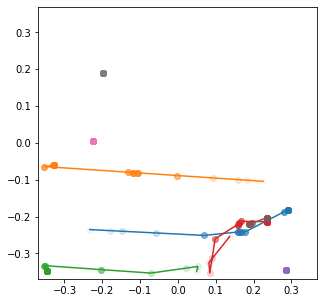

In [23]:
ic_file_name = './sample_ic_random.txt'
data_file_name = './sample_ic_random_output.txt'
ncoins = np.random.randint(3,12)
moving = np.random.randint(2,ncoins)
make_ics(ic_file_name, ncoins, moving)
simulator_engine(ic_file_name, data_file_name)
fig = sim_viewer(data_file_name, ncoins)
plt.savefig('./outviz.png')
plt.show()